# Working with raster data and points

**Author**: Andrea Ballatore (Birkbeck, University of London)

**Abstract**: Learn how to load, process, and save geospatial raster data using Python packages.

**Credits**: Code adapted from:
- https://automating-gis-processes.github.io/CSC18/lessons/L6/zonal-statistics.html 
- https://automating-gis-processes.github.io/CSC/notebooks/L5/reading-raster.html
- https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
- https://residentmario.github.io/geoplot/gallery/plot_boston_airbnb_kde.html

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [1]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'geoprogv1':
    raise Exception("Set the environment 'geoprogv1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import fiona as fi
import pandas as pd
import geopandas
import pysal as sal
import math
import geoplot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import rasterio
import rasterio.plot
import rasterstats

# create tmp folder
if not os.path.exists('tmp'):
    os.makedirs('tmp')
# make sure the 'data' folder exists
if not os.path.exists('data'):
    os.makedirs('data')

print('env ok')

Conda env: geoprogv1
env ok


----
## Raster data

- Raster data represents samples from a continuous **field**, such as temperature, or gas densities, or vegetation density, etc. 
- A raster dataset is usually a matrix with two dimensions:

<img src="img/raster_matrix1.png" width=400/>

- A raster **cell** can be referred to with a bi-dimensional index, indicating a <row,column> pair. These indices start from 0.
- Each index location can be associated with a geo-location (for example, cell <12,796> might be corresponding to lon/lat <-0.34521,51.354656>). 
- Note that, when we work with raster data, we are frequently switching from the raster index to the geolocations and back.
- If a raster dataset contains more than a matrix, we refer to the different matrices as **bands**. Bands are counted from 1. For example, a raster produced from a satellite can contain 3 bands representing the intensity of red, green, and blue.

## Python packages for raster data

- Python does not have a single standard package that provides all functionality to work with raster data.
- As is often the case, in Python we use a **combination** of highly specialised packages to achieve a goal.
- `rasterio`: this package can read and write raster data (https://rasterio.readthedocs.io).
- `rasterstats`: this package provides functionality for zonal statistics (https://pythonhosted.org/rasterstats).
- `gdal`: many packages in Python (and other languages) rely on this old but robust library that provides hundreds of geospatial functions, including vector and raster processing (https://gdal.org).
- `numpy`: this package supports fast operations on numeric matrices that are the core of geospatial raster processing.
- In this notebook we will use primarily `rasterio` to load and interact with raster data.

## Downloading files from the web

- In programming, we can interact with files on the local hard drive, but also download files from the web.
- This is very useful for example to download large amounts of files from an online repository.
- Often, large datasets are split into smaller chunks and downloading them manually can be very time consuming.
- This functionality can also be used to access API and get results automatically.
- In this example, we will download files from a GitHub repository, downloading a raster file with package `urllib`:

In [2]:
import urllib.request
# Download the file from `url` and save it locally unde 'file_name':
url = 'https://github.com/andrea-ballatore/open-geo-data-education/blob/main/datasets/eu_air_quality_2016/eu-2016-nox_avg.tif?raw=true'
file_name = 'data/eu-2016-nox_avg.tif'
urllib.request.urlretrieve(url, file_name)

('data/eu-2016-nox_avg.tif', <http.client.HTTPMessage at 0x1091a2d30>)

## Open and plot a raster file

- This file contains the estimated average Nitrate and Nitrite (NOx) in the European Union from https://airindex.eea.europa.eu.
- NOx is an important element of air pollution. These gases contribute to smog and acid rain and can affect the tropospheric ozone. For more details, see http://www.apis.ac.uk/overview/pollutants/overview_nox.htm.
- The data is in ETRS89 Lambert Azimuthal Equal Area CRS, commonly used for equal-area European data.
- Each cell cover approximately 2 km$^2$.
- Now can use `rasterio` to explore the content of this raster dataset:

In [3]:
# Note that when we open a file, rasterio does not load it in memory.
# This is a good approach as raster files can be very large.
nox_rast = rasterio.open('data/eu-2016-nox_avg.tif', mask=True)
nox_rast

<open DatasetReader name='data/eu-2016-nox_avg.tif' mode='r'>

In [4]:
# explore content
print("Number of bands:", nox_rast.count)
print("Width:", nox_rast.width)
print("Height:", nox_rast.height)

Number of bands: 1
Width: 2340
Height: 2019


In [5]:
# The data is in ETRS89 Lambert Azimuthal Equal Area CRS (EPSG:3035)
print("CRS:", nox_rast.crs)
print("Bounds:", nox_rast.bounds)
print("Value for no data:", nox_rast.nodata)

CRS: EPSG:3035
Bounds: BoundingBox(left=2636000.0, bottom=1386000.0, right=7316000.0, top=5424000.0)
Value for no data: 0.0


In [6]:
# all meta data
print(nox_rast.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 2340, 'height': 2019, 'count': 1, 'crs': CRS.from_epsg(3035), 'transform': Affine(2000.0, 0.0, 2636000.0,
       0.0, -2000.0, 5424000.0)}


In [7]:
# As rasterio's visualisation functionality is quite complicated,
# we create a function to visualise a raster more easily.
# Based on https://geoscripting-wur.github.io/PythonRaster
# Note the default values (Blues, 10, 10).
# In terms of complexity, this is a realistic function used in data science, with 
# hacks to make things work because of the package limitations.
def plot_raster(rast, val_matrix, plot_title, value_label, cmap='Blues', width=10, height=10, diverge_zero=False):
    """Plots a rasterio raster with sensible settings and with a legend .
        @ rast: rasterio file (used to read the geocoordinates)
        @ val_matrix: extracted values (used to read the raster values)
        @ plot_title: title of the whole figure
        @ value_label: quantity being displayed
        @ diverge_zero: true if using a divergent cmap to center colour map on zero
    """
    fig, ax = plt.subplots(figsize=(10,10))
    # image_hidden is a hack to show the legend
    if diverge_zero:
        image_hidden = ax.imshow(val_matrix, cmap=cmap, norm=TwoSlopeNorm(0))
    else:
        image_hidden = ax.imshow(val_matrix, cmap=cmap)

    ax.clear()
    # plot raster: rast.transform allows the system to show geocoordinates
    if diverge_zero:
        rast_plot = rasterio.plot.show(val_matrix, cmap=cmap, ax=ax, transform=rast.transform, norm=TwoSlopeNorm(0))
    else: 
        rast_plot = rasterio.plot.show(val_matrix, cmap=cmap, ax=ax, transform=rast.transform)
    # set plot title
    ax.set_title(plot_title, fontsize=14)
    # show legend with label
    # hack to fix height
    im_ratio = val_matrix.shape[0]/val_matrix.shape[1] 
    #plt.colorbar(im,fraction=0.046*im_ratio, pad=0.04)
    cbar = fig.colorbar(image_hidden, ax=ax, fraction=0.046*im_ratio, pad=0.04)
    cbar.ax.set_ylabel(value_label, rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    #ax.set_axis_off() # enable/disable axes
    plt.show()

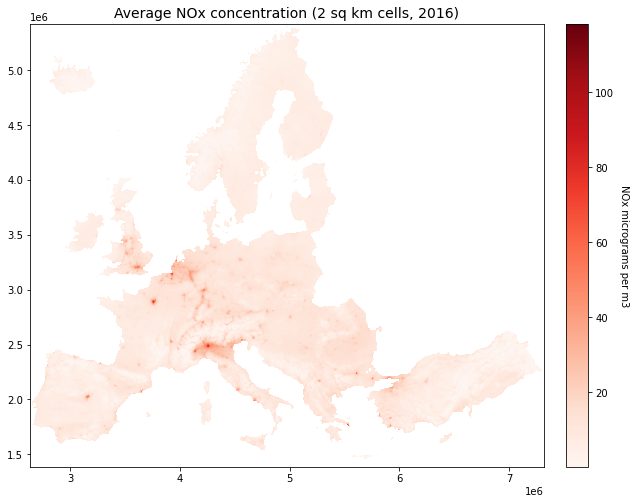

In [8]:
# read band and plot it with pseudocolour.
# Note that we have to read the band with .read(1) (as rasterio does not load it).
# The plot shows the cell numbers and not the corresponding geo-coordinates.

# masked=True is very important to tell rasterio to ignore the NULL values (in this case
# cells for which we do not have NOx values).
plot_raster(nox_rast, nox_rast.read(1, masked=True), 
            'Average NOx concentration (2 sq km cells, 2016)', 
            'NOx micrograms per m3', cmap='Reds', width=14, height=14)

- A basic raster operation is to **read the value** at a given point.
- The raster represents the annual average concentration of NOx in 2016, measured in micrograms in each cubic metre of air ($\mu g$/m$^{3}$):


In [9]:
# a point in Paris (in Lambert projection)
paris_centroid_lamb = [3758948, 2889291]
# get row/column in raster corresponding to the geo-location paris_centroid_lamb
loc_idx = nox_rast.index(paris_centroid_lamb[0], paris_centroid_lamb[1])
print("cell location in raster:",loc_idx)

cell location in raster: (1267, 561)


In [10]:
# read value
nox_val = nox_rast.read(1)[loc_idx]
print("NOx value in Paris:",nox_val)

NOx value in Paris: 99.333


## Raster histogram
- As always, it is important to observe the distribution of values with a histogram.
- Note that the recommended NOx limit for the EU is 40. Luckily, most areas appear below that limit, but it is possible to observe some cells with very high values.

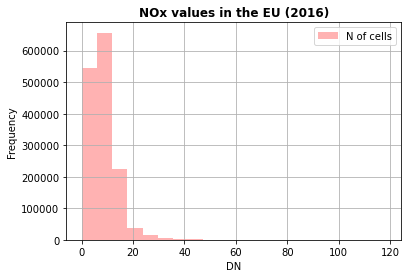

In [11]:
from rasterio.plot import show_hist

# plot histogram of raster values
show_hist(nox_rast, bins=20, lw=0.0, stacked=False, alpha=0.3, label='N of cells',
    histtype='stepfilled', title="NOx values in the EU (2016)")

## Raster reclassification

- Internally, a raster dataset in Python is an object of type `numpy.ndarray`, from package `numpy`.
- This is a **multidimensional array**, which is an intuitive way to represent multi-band raster datasets.
- This powerful data structure is used in scientific computing (see this [manual](https://numpy.org/doc/stable/reference/arrays.ndarray.html) and this [tutorial](https://numpy.org/doc/stable/user/quickstart.html)).
- It supports fast operations on rows and columns. 
- For example, we can count and show areas with NOx > 40.
- The **reclassification** of a raster is a common operation where a new raster is produced based on a classification:

<img src="img/reclassify1.png" width=400 />

[(image source)](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/understanding-reclassification.htm)

- In the case of NOx, we can **reclassify** the raster values according to these categorisation:
  - [0, 20): low (cat = 1)
  - [20, 40): medium (cat = 2)
  - [40, 60): high (cat = 3)
  - [60, $\infty$): critical (cat = 4)
- This is a common raster operation:

In [12]:
# get matrix with raster values
vals = nox_rast.read(1, masked=True)
print(type(vals))
print("Size of matrix:", vals.shape) # x y

<class 'numpy.ma.core.MaskedArray'>
Size of matrix: (2019, 2340)


In [13]:
# select only values > 40
high_vals = vals[vals>40]
print(len(high_vals),'cells have high NOx values (>40 micrograms/m3).')
print('% of total cells:',(len(high_vals)/(vals.shape[0]*vals.shape[1]))*100)

3171 cells have high NOx values (>40 micrograms/m3).
% of total cells: 0.06711878182903443


In [14]:
# reclassification:
# copy matrix to preserve the original data
recl_vals = vals.copy()

# apply new categorisation (4 = very high values)
# Note that the order of these operations is important to achieve a correct
# reclassification.
recl_vals[vals > 0] = 4
# if vals < 60 set value to 3
recl_vals[vals < 60] = 3
# if vals < 40 set value to 2
recl_vals[vals < 40] = 2
# if vals < 20 set value to 1
recl_vals[vals < 20] = 1

- Now we can plot the reclassified raster, attracting attention to areas with high NOx values:

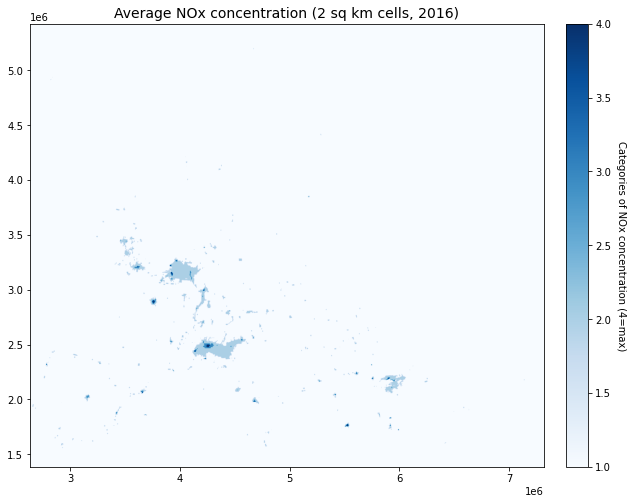

In [15]:
# show result
plot_raster(nox_rast, recl_vals, 'Average NOx concentration (2 sq km cells, 2016)', 
    'Categories of NOx concentration (4=max)', cmap='Blues', width=14, height=14)

- From this plot, you can see areas of relatively high air pollution emerge: The Po Valley in Northern Italy, Paris, London, and Madrid. Can you identify others?

## Digital elevation models (DEM)

- DEM are a common type of raster that represents elevation.
- This dataset represent the elevation of the Himalayas at a resolution of 1 km (see [source](https://github.com/andrea-ballatore/open-geo-data-education/tree/main/datasets/digital_elevation_models)).


In [16]:
import urllib.request
# Download the file from `url` and save it locally unde 'file_name':
url = 'https://github.com/andrea-ballatore/open-geo-data-education/blob/main/datasets/digital_elevation_models/dem_srtm_1km_himalayas_2009.tif?raw=true'
rast_file_name = 'data/dem_srtm_1km_himalayas_2009.tif'
urllib.request.urlretrieve(url, rast_file_name)

('data/dem_srtm_1km_himalayas_2009.tif',
 <http.client.HTTPMessage at 0x1679f0580>)

### Visualise a DEM

- Let us explore the data with `rasterio`:

In [17]:
him_rast = rasterio.open('data/dem_srtm_1km_himalayas_2009.tif')
print(him_rast.meta)
print(him_rast.bounds)

{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -32768.0, 'width': 5013, 'height': 4484, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008333333332934371, 0.0, 65.333333323,
       0.0, -0.008333333332961641, 53.416666662)}
BoundingBox(left=65.333333323, bottom=16.049999997, right=107.108333321, top=53.416666662)


In [18]:
# Note that we have to read a band (as rasterio does not load it).
# The plot shows the cell numbers and not the corresponding geo-coordinates.
vals = him_rast.read(1, masked=True)

# print basic statistics
print("Min value (m):",vals.min())
# note that for the median we use np.median 
print("Median value (m):",np.median(vals))
print("Max value (m):",vals.max())

Min value (m): -161
Median value (m): 975.0
Max value (m): 8496


/Users/andreab/opt/anaconda3/envs/geoprogv1/lib/python3.9/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


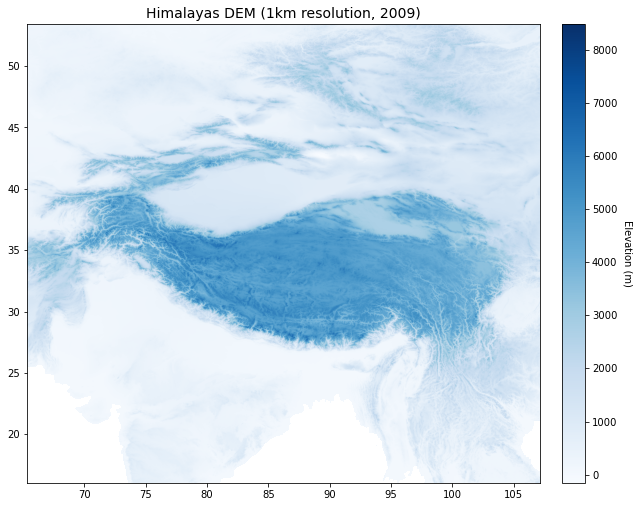

In [19]:
plot_raster(him_rast, vals, 'Himalayas DEM (1km resolution, 2009)', 'Elevation (m)')

### DEM operations with GDAL

- We can use `gdal` to perform basic operations of this DEM.
- Note that `gdal` reads and writes files directly, without loading them in memory. The style of `gdal` is more similar to ArcGIS than Python, which usually prefers to create and process data directly in memory.
- `gdal.DEMProcessing(...)` supports many common raster operations, such as **aspect**, **slope**, and **hillshade**: 

In [20]:
# import GDAL package
from osgeo import gdal

input_raster = 'data/dem_srtm_1km_himalayas_2009.tif'

help(gdal.DEMProcessing)

Help on function DEMProcessing in module osgeo.gdal:

DEMProcessing(destName, srcDS, processing, **kwargs)
    Apply a DEM processing.
    Arguments are :
      destName --- Output dataset name
      srcDS --- a Dataset object or a filename
      processing --- one of "hillshade", "slope", "aspect", "color-relief", "TRI", "TPI", "Roughness"
    Keyword arguments are :
      options --- return of gdal.DEMProcessingOptions(), string or array of strings
      other keywords arguments of gdal.DEMProcessingOptions()
    If options is provided as a gdal.DEMProcessingOptions() object, other keywords are ignored.



In [21]:
# calculate aspect
out_raster = 'tmp/dem_srtm_1km_himalayas_2009_aspect.tif'
out = gdal.DEMProcessing(out_raster, input_raster, 'aspect')
# make sure file is written out
out.FlushCache()

In [22]:
aspect_rast = rasterio.open(out_raster).read(1, masked=True)
print("aspect range: ",aspect_rast.min(),aspect_rast.max())

aspect range:  0.0 359.9881


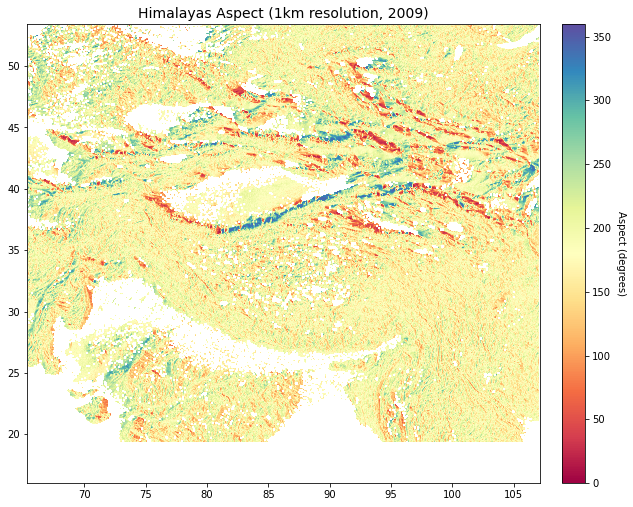

In [23]:
plot_raster(rasterio.open(out_raster), aspect_rast, 
            'Himalayas Aspect (1km resolution, 2009)', 
            'Aspect (degrees)', cmap="Spectral", width=3)

In [24]:
# calculate hillshade
out_raster = 'tmp/dem_srtm_1km_himalayas_2009_hillshade.tif'
out = gdal.DEMProcessing(out_raster, input_raster, 'hillshade')
# make sure the file is written
out.FlushCache()
# out_raster should exist at this point

In [25]:
hillshade_rast = rasterio.open(out_raster).read(1, masked=True)
print("hillshade range (degrees):",hillshade_rast.min(),hillshade_rast.max())

hillshade range (degrees): 1 189


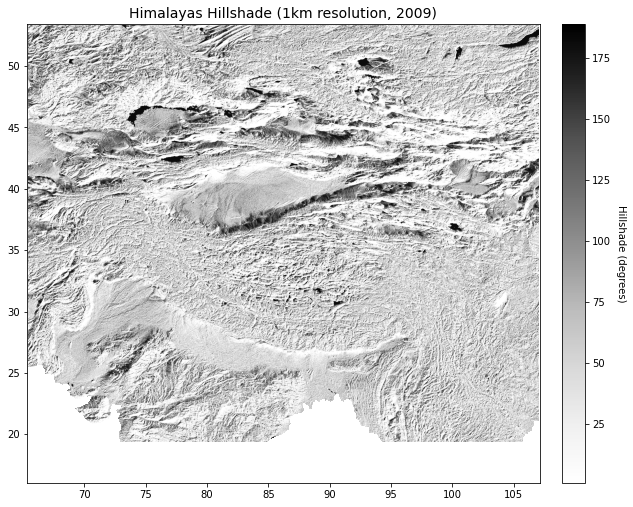

In [26]:
plot_raster(rasterio.open(out_raster), hillshade_rast, 
            'Himalayas Hillshade (1km resolution, 2009)',
            'Hillshade (degrees)', cmap="Greys", width=3)

## Points and Kernel Density Estimation

- When working with point datasets, we might want to produce a raster to study the point density pattern.
- Visualising points with a simple **scatter plot** is usually not good practice, as we cannot see the data density.
- Grids or bi-dimensional histograms are better, but still scientifically not ideal.
- The best approach is to produce a **Kernel Density Estimate (KDE)**, which is a density field that captures point density much better.

### Load point dataset

- This dataset contains the approximate locations of historical shipwrecks (see [DARMC source](https://github.com/andrea-ballatore/open-geo-data-education/tree/main/datasets/darmc_historical_shipwrecks_500bce_1500ce) for details).

In [27]:
# Download the file from `url` and save it locally unde 'file_name':
url = 'https://github.com/andrea-ballatore/open-geo-data-education/raw/main/datasets/darmc_historical_shipwrecks_500bce_1500ce/darmc_historical_shipwrecks_500bce_1500ce.geojson?raw=true'
file_name = 'data/darmc_historical_shipwrecks_500bce_1500ce.geojson'
urllib.request.urlretrieve(url, file_name)

('data/darmc_historical_shipwrecks_500bce_1500ce.geojson',
 <http.client.HTTPMessage at 0x167a75160>)

In [28]:
# Download country boundaries too
url = 'https://github.com/andrea-ballatore/open-geo-data-education/raw/main/datasets/world_country_boundaries_2018/natural_earth_world_boundaries_50m_2018.geojson?raw=true'
file_name = 'data/natural_earth_world_boundaries_50m_2018.geojson'
urllib.request.urlretrieve(url, file_name)

('data/natural_earth_world_boundaries_50m_2018.geojson',
 <http.client.HTTPMessage at 0x167b4d310>)

- Each row in the data frame represents a shipwreck, with spatial, temporal, and thematic attributes (e.g., type of cargo).
- We can plot these points directly, but this does not allow us to see the spatial distribution of the points accurately, even using transparency (`alpha`):

In [29]:
# load datasets and project them to 3035 (Lambert, suitable for Europe)
ship_df = geopandas.read_file('data/darmc_historical_shipwrecks_500bce_1500ce.geojson').to_crs(3035)
countries_df = geopandas.read_file('data/natural_earth_world_boundaries_50m_2018.geojson').to_crs(3035)

# see sample of the data
ship_df.sample(5)

,2010_wreck_id,name_1,name_2,start_date,end_date,year_found,depth,depth_q,length,width,cargo_1,type_1,cargo_2,type_2,cargo_3,type_3,other_cargo,geometry
352,134.0,Camerat 1,None,1.0,100.0,None,25.0,None,None,NaN,tiles,"imbrices, tegulae",None,None,None,None,None,POINT (4050782.840 2238437.770)
177,755.0,Punta Blanca,None,-50.0,25.0,None,NaN,None,None,NaN,amphoras,Pascual1,None,None,None,None,None,POINT (3768984.588 2159140.217)
245,832.0,Saint-Gervais 4,None,50.0,150.0,None,6.0,None,None,NaN,amphoras,Dr20 Beltran2B,None,None,None,None,None,POINT (3909929.824 2270354.703)
952,903.0,Sobra,None,320.0,340.0,None,30.0,None,25,NaN,amphoras,"Afr cylindrical, Al50, pear-shaped",ceramic,"terra sigillata chiara D, cooking pot, jug",None,None,None,POINT (4944285.717 2210439.711)
683,85.0,Borgo Caprile,None,500.0,1100.0,None,NaN,None,10,NaN,nothing reported,None,None,None,None,None,None,POINT (4493225.105 2393855.581)


### Point plot

- Let us plot the shipwrecks locations on the shorelines with `geoplot.pointplot(...)`.
- This plot allows to see where the points are located, but it suffers from occlusion.

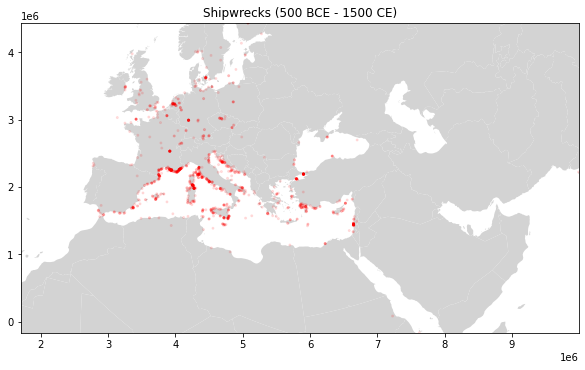

In [30]:
# define canvas
f, ax = plt.subplots(figsize=(10,7))
# plot two layers
countries_df.plot(ax=ax, color='lightgray', edgecolor="none", linewidth=.5)
geoplot.pointplot(ship_df, s=2, color='red', ax=ax, alpha=.1)
# set map bounds
# create buffer to add a margin
buff = ship_df.buffer(1)
xlim = ([buff.total_bounds[0], buff.total_bounds[2]])
ylim = ([buff.total_bounds[1], buff.total_bounds[3]])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('Shipwrecks (500 BCE - 1500 CE)')
ax.set_axis_on()
# show result
plt.show()

### 2D histogram

- A better way to represent a spatial density is a **two-dimensional histogram** (`hist2d`), also known as a grid plot.
- Note that one of the advantages of Python is the possibility of varying parameters of a function through a `for` loop (for example, the number of bins in a histogram) and compare the results.
- These plots indicates the presence of an area of extremely high density between France, Corsica, and Italy:

bin_n 10


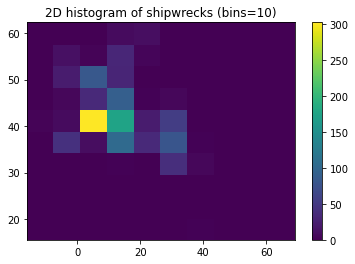

bin_n 20


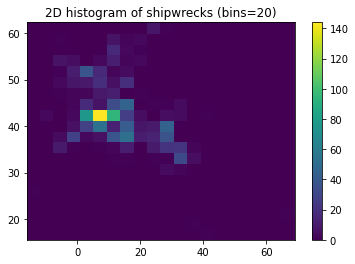

bin_n 30


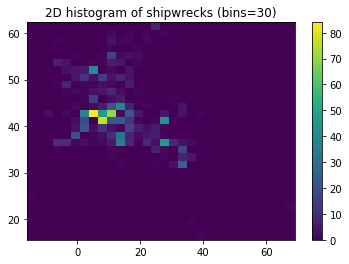

bin_n 40


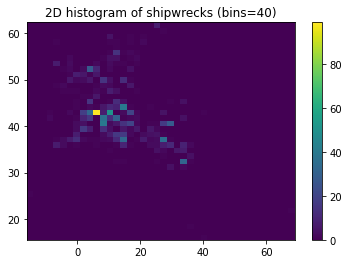

In [31]:
# reproject back to lon/lat to have more 
# interpretable coordinates
ship_df = ship_df.to_crs(4326)

# let's vary the number of bins:
for bin_n in [10,20,30,40]:
    print("bin_n",bin_n)
    h = plt.hist2d(ship_df.geometry.x, ship_df.geometry.y, bins=bin_n, density=False)
    plt.colorbar(h[3])
    plt.title('2D histogram of shipwrecks (bins='+str(bin_n)+")")
    plt.show()

### KDE plot

- A more scientific approach consists of a **kernel density estimation (KDE)**. See this [background discussion](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/how-kernel-density-works.htm).
- `geoplot.kdeplot(...)` can plot a KDE starting from point data.
- A crucial parameter is the **bandwidth** (`bw`), which is the distance threshold used to produce the surface (shorter distances result in a more detailed surface):


bandwidth: 0.1


/Users/andreab/opt/anaconda3/envs/geoprogv1/lib/python3.9/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


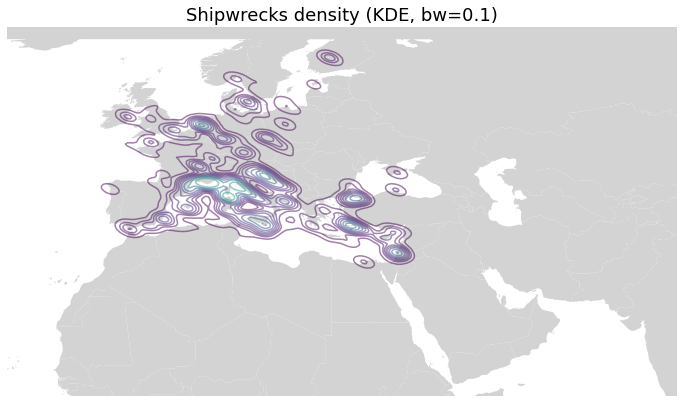

bandwidth: 0.2


/Users/andreab/opt/anaconda3/envs/geoprogv1/lib/python3.9/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


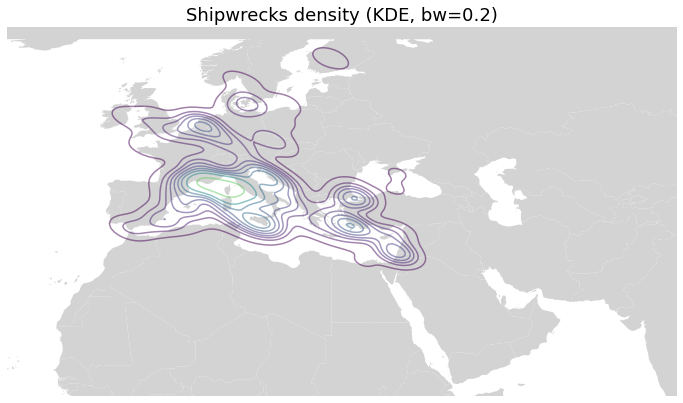

bandwidth: 0.3


/Users/andreab/opt/anaconda3/envs/geoprogv1/lib/python3.9/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


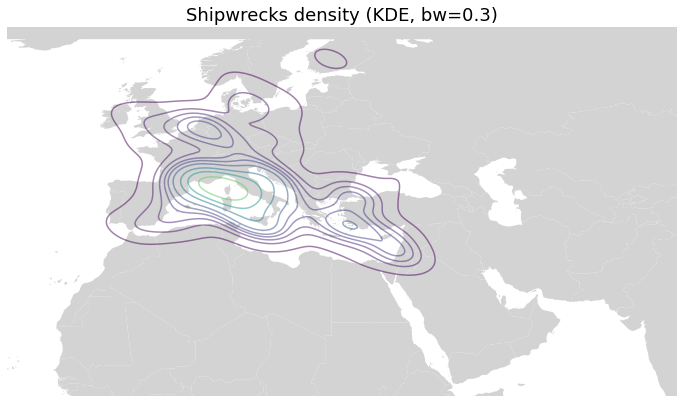

bandwidth: 0.4


/Users/andreab/opt/anaconda3/envs/geoprogv1/lib/python3.9/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


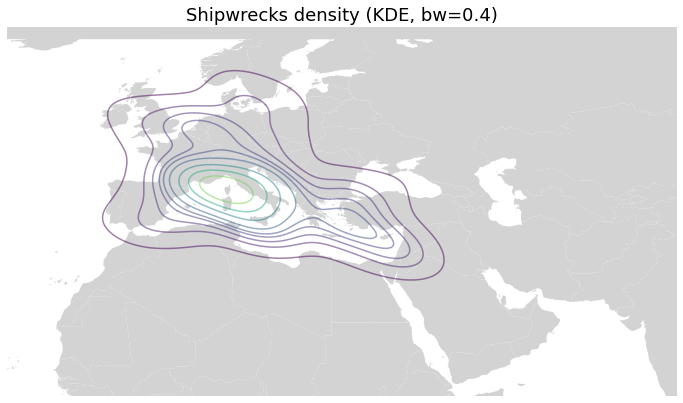

In [32]:
# transform back to lon/lat
ship_df_ll = ship_df.to_crs(4326)

# generate different KDE with different bandwiths
for bandwidth in [.1, .2, .3, .4]:
    print("bandwidth:",bandwidth)
    # plot KDE contours
    ax = geoplot.kdeplot(ship_df_ll, shade=False, bw=bandwidth, figsize=(12, 12), alpha=.5)
    # add shorelines
    countries_df.to_crs(4326).plot(ax=ax, color='lightgray', edgecolor="none", linewidth=.5)
    # add title
    plt.title('Shipwrecks density (KDE, bw='+str(bandwidth)+")", fontsize=18)
    # show figure
    plt.show()

- These KDE plots indicate that the dataset has a very high concentration of points in the Mediterranean Sea, between Southern France, Corsica, and the Western Coast of Italy. In all plots this gravitational centre emerges very clearly.
- Scientifically, this might indicate that either there were many more shipwrecks there than elsewhere or (more likely) that the historical record is richer and more detailed for that area, for example because there were institutions.
- Note that this KDE uses a Gaussian estimator, and others exist (see https://seaborn.pydata.org/generated/seaborn.kdeplot.html).
- The determination of an appropriate bandwidth is a non-trivial scientific problem. See for example this [review article (Ruckthongsook et al., 2018)](https://ij-healthgeographics.biomedcentral.com/articles/10.1186/s12942-018-0129-9).
- The important message here is that KDE is the best way to expose point density patterns.
- For advanced visualisations of density, see https://seaborn.pydata.org/tutorial/distributions.html

## Map Algebra
- The term _map algebra_ refers to the idea of applying algebraic operations to raster datasets.
- For example, we might want to subtract two  temperature rasters captured at different times to observe the temperature variation:

<img src="img/map_algebra1.png" width=500>

- In practice, this is an arithmetic operation applied to each cell of both raster:


<img src="img/map_algebra2.png" width=280>

([images source](https://gisgeography.com/map-algebra-global-zonal-focal-local/))

### Map algebra in Python
- When accessing rasters with `rasterio` or `gdal`, we can perform any linear algebra calculations on the data using `numpy`, `scipy` and many other powerful Python packages. Zonal statistics is supported by the `rasterstats` package.
- This is the main reason why Python is widely used in the remote sensing, machine learning, and AI communities. Python provides the ideal environment to develop and test new algorithms, both in research and industry.

### Load temperature data
- As an example, let us download and visualise two raster datasets representing average temperature at a coarse resolution, in 2000 and 2017.
- The source is the 1900-2017 Gridded Monthly Time Series by Kenji Matsuura and Cort J. Willmott (University of Delaware):

In [33]:
url = "https://github.com/andrea-ballatore/open-geo-data-education/blob/main/datasets/global_air_temperature_1950_2017/rasters/air_temp_2000-average.tif?raw=true"
file_name = 'data/air_temp_2000-average.tif'
urllib.request.urlretrieve(url, file_name)

url = "https://github.com/andrea-ballatore/open-geo-data-education/blob/main/datasets/global_air_temperature_1950_2017/rasters/air_temp_2017-average.tif?raw=true"
file_name = 'data/air_temp_2017-average.tif'
urllib.request.urlretrieve(url, file_name)

('data/air_temp_2017-average.tif', <http.client.HTTPMessage at 0x16850db80>)

In [34]:
temp00 = rasterio.open('data/air_temp_2000-average.tif')
print(temp00.meta)
temp17 = rasterio.open('data/air_temp_2017-average.tif')
print(temp17.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 720, 'height': 347, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 83.5)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 720, 'height': 347, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.5, 0.0, -180.0,
       0.0, -0.5, 83.5)}


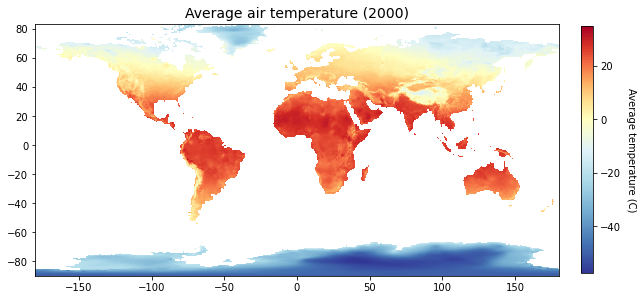

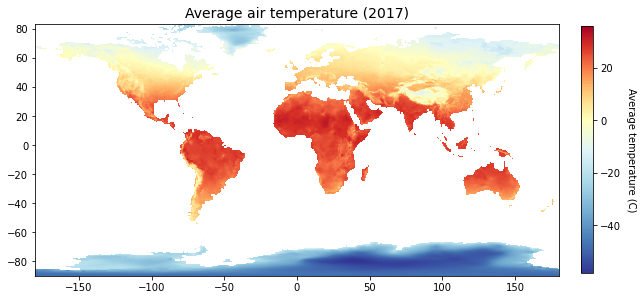

In [35]:
# note the diverge_zero: this is used because temperature in Celsius can be visualised as diverging from zero
plot_raster(temp00, temp00.read(1, masked=True), 'Average air temperature (2000)', 'Average temperature (C)', 
    'RdYlBu_r', diverge_zero=True)
plot_raster(temp17, temp17.read(1, masked=True), 'Average air temperature (2017)', 'Average temperature (C)', 
    'RdYlBu_r', diverge_zero=True)

### Subtract two rasters

- Visually, it is not possible to spot differences between 2000 and 2017 data.
- Hence, in the next cell, we will subtract two temperature rasters, using Map Algebra. In pratice, Python allows to do this as intuitively as `raster_vals2 - raster_vals1`. These are linear algebra operations applied to each cell of the matrices.
- Then we plot a histogram of the values and the raster, showing that the average temperatures are higher by 0.5 degrees, with some extremes positive and negative cases that might be due to sensor errors.
- The result will be saved into a new raster file, reusing the meta-data from the input rasters.

In [36]:
vals17 = temp17.read(1, masked=True)
vals00 = temp00.read(1, masked=True)
# subtract the two rasters
vals_diff = vals17 - vals00
print("Difference stats:", vals_diff.min(), round(vals_diff.mean(),2), vals_diff.max())
print("Difference between means:", round(vals17.mean()-vals00.mean(),3))

Difference stats: -19.0 0.52 17.1
Difference between means: 0.523


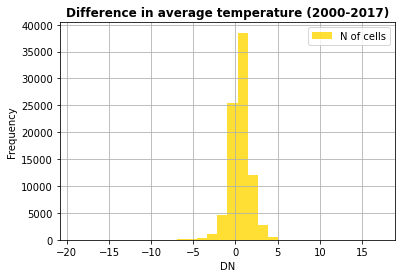

In [37]:
# plot histogram
show_hist(vals_diff, bins=30, lw=0.2, stacked=False, alpha=0.8, label='N of cells',
    histtype='stepfilled', title="Difference in average temperature (2000-2017)")

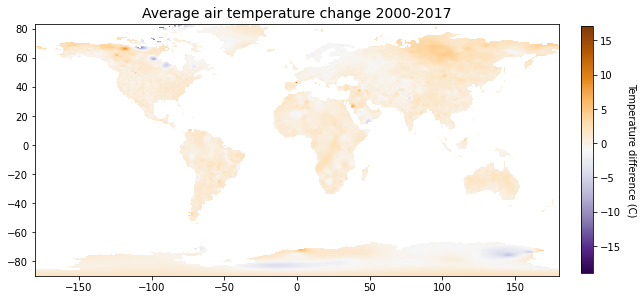

In [38]:
# plot raster. This cmap (Purple - White - Orange) tends to emphasies the extreme values, 
# hiding the areas where the values are not diverging.
plot_raster(temp17, vals_diff, 'Average air temperature change 2000-2017', 
            'Temperature difference (C)', 'PuOr_r')

In [39]:
# save the result of the calculation into a new raster file.
# It is important to specify the metadata from the input files, including 
# the CRS, the NODATA value, and the geocoordinate transformation:
fout = 'tmp/air_temp_diff_2000_2017.tif'
ds = rasterio.open(fout, 'w', 
    driver='GTiff', # output format
    height=vals_diff.shape[0], # size of matrix
    width=vals_diff.shape[1], # size of matrix
    count=1, # number of bands
    dtype=vals_diff.dtype, # type of data (e.g., floating point)
    crs=temp17.crs, # CRS (e.g., Lambert, WGS84, UTM, etc.)
    nodata=temp17.nodata, # value used to represent NO DATA
    transform=temp17.transform # geocoordinate transformation
)

ds.write(vals_diff, 1)
ds.close()
print("Raster written in", fout, '.')

Raster written in tmp/air_temp_diff_2000_2017.tif .


## Zonal statistics

- When we want to calculate raster statistics based on a zonal geography, we need to use **zonal statistics**. For example, we might want to calculate the average elevation (values) of each county (zones) in England.
- As input, zonal statistics need a raster representing the values and another dataset representing the areas for which we want to calculate the statistics:

<img src="img/zonal1.png" width=400 />

[(Image source)](https://community.esri.com/)

- In this example, we will use the European NOx data used above as values and European statistical areas (NUTS) as zones.

### Download data

- The file is gzipped and we can open it directly with `gzip.open(...)`.

In [40]:
# download EU regional boundaries (NUTS level 2, 2021)
nuts2_file = 'data/NUTS_RG_01M_2021_4326_LEVL_2.geojson.gz'
url = 'https://github.com/andrea-ballatore/open-geo-data-education/blob/main/datasets/eu_eurostat_indicators_2005_2020/nuts_boundaries/nuts_bounds_2021/NUTS_RG_01M_2021_4326_LEVL_2.geojson.gz?raw=true'
urllib.request.urlretrieve(url, nuts2_file)

('data/NUTS_RG_01M_2021_4326_LEVL_2.geojson.gz',
 <http.client.HTTPMessage at 0x167ed7e20>)

<AxesSubplot:>

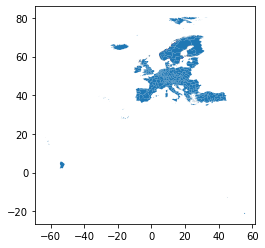

In [41]:
import gzip
nuts2_df = geopandas.read_file(gzip.open(nuts2_file))
nuts2_df.plot()

In [42]:
nuts2_df.sample(5)

,id,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,FID,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,geometry
186,IS00,NaN,0,Ísland,IS,IS00,IS00,Ísland,2,NaN,"MULTIPOLYGON (((-22.00740 63.83599, -22.03591 ..."
208,PL62,NaN,0,Warmińsko-mazurskie,PL,PL62,PL62,Warmińsko-mazurskie,2,NaN,"POLYGON ((21.55932 54.32250, 21.56927 54.32227..."
219,SI04,NaN,0,Zahodna Slovenija,SI,SI04,SI04,Zahodna Slovenija,2,NaN,"POLYGON ((14.43450 46.44294, 14.43805 46.44128..."
71,EL51,NaN,0,"Anatoliki Makedonia, Thraki",EL,EL51,EL51,"Aνατολική Μακεδονία, Θράκη",2,NaN,"MULTIPOLYGON (((26.35788 41.71110, 26.36917 41..."
320,TR22,NaN,0,"Balıkesir, Çanakkale",TR,TR22,TR22,"Balıkesir, Çanakkale",2,NaN,"MULTIPOLYGON (((28.16478 40.39561, 28.16460 40..."


### Data preparation

- As we do not have data for French Guyana and other smaller territories, we can remove them from the dataset.
- In `pandas` data frames, we can write where conditions in a variety of ways:
  - `column.str.contains(string)` performs a partial match on a string column 
  - `column.isin(list)` performs an exact match on the content of a column against a list
  - `~` means `not` (only in the context of `pandas`)
- We are then projecting the boundaries and saving them into a **GeoPackage**. Bear in mind that GeoJSON only allows geometries in WGS84 (4326). When you have other CRS, you should use a GeoPackage.

In [43]:
# this expression means:
# select rows where NUTS_ID does NOT contain 'FRY'
nuts2_df = nuts2_df[~nuts2_df['NUTS_ID'].str.contains("FRY")]
# remove rows with codes corresponding to islands for which we do not have data:
nuts2_df = nuts2_df[~nuts2_df['NUTS_ID'].isin(['PT20','PT30','ES70','NO0B'])]
# project to Lambert (suitable for Europe)
nuts2_df = nuts2_df.to_crs(3035)
nuts2_df.info()

# this is a fix: geo data frames need the FID to be of type integer
nuts2_df['FID'] = nuts2_df.index

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 325 entries, 0 to 332
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          325 non-null    object  
 1   COAST_TYPE  6 non-null      float64 
 2   MOUNT_TYPE  325 non-null    int64   
 3   NAME_LATN   325 non-null    object  
 4   CNTR_CODE   325 non-null    object  
 5   FID         325 non-null    object  
 6   NUTS_ID     325 non-null    object  
 7   NUTS_NAME   325 non-null    object  
 8   LEVL_CODE   325 non-null    int64   
 9   URBN_TYPE   6 non-null      float64 
 10  geometry    325 non-null    geometry
dtypes: float64(2), geometry(1), int64(2), object(6)
memory usage: 30.5+ KB


In [44]:
# save this dataset to a file
nuts2_clean_file = "tmp/nuts2_boundaries.gpkg"
nuts2_df.to_file(nuts2_clean_file, driver="GPKG")

<AxesSubplot:>

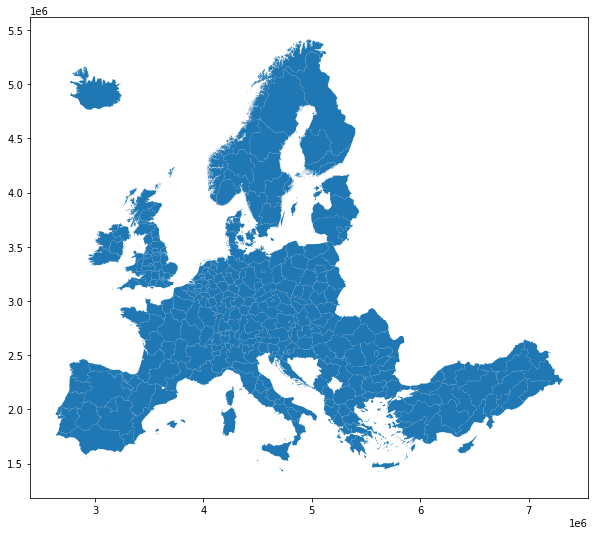

In [45]:
# plot geometries
nuts2_df.plot(figsize=(10,10))

### Zonal statistics in Python 

- Zonal statistics can be calculated with the `rasterstats.zonal_stats` function (see manual at https://pythonhosted.org/rasterstats/manual.html).
- The parameter `stats` indicates which statistics we want to calculated in each zone.
- In the next cell, we will calculate several zonal statistics and save the result into a GeoPackage and a CSV file:

In [46]:
from rasterstats import zonal_stats
print("calculating zonal stats between",nuts2_clean_file,'and data/eu-2016-nox_avg.tif ...')

zon_stats = zonal_stats(nuts2_clean_file, 'data/eu-2016-nox_avg.tif', 
                        stats="count min mean max median", geojson_out=True)
print('done.')

calculating zonal stats between tmp/nuts2_boundaries.gpkg and data/eu-2016-nox_avg.tif ...


/Users/andreab/opt/anaconda3/envs/geoprogv1/lib/python3.9/site-packages/rasterstats/io.py:94: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in src:


done.


In [47]:
# the results is a list of dictionary containing the statistics for each row of the input vector file
# These results can be converted into a geo data frame this way:
stats_df = geopandas.GeoDataFrame.from_features(zon_stats)

# rename columns to be more meaningful
stats_df = stats_df.rename(columns={"min": "nox_min", 
                                    "max": "nox_max", 
                                    "count": "nox_count", 
                                    "mean": "nox_mean", 
                                    "median": "nox_median"})
stats_df.sample(4)

,geometry,id,COAST_TYPE,MOUNT_TYPE,NAME_LATN,CNTR_CODE,NUTS_ID,NUTS_NAME,LEVL_CODE,URBN_TYPE,nox_min,nox_max,nox_mean,nox_count,nox_median
56,"MULTIPOLYGON (((3735722.439 1899591.154, 37359...",ES53,NaN,0,Illes Balears,ES,ES53,Illes Balears,2,NaN,0.05,48.764999,7.724231,1248,6.449000
90,"POLYGON ((5080508.322 3065872.586, 5080260.235...",PL21,NaN,0,Małopolskie,PL,PL21,Małopolskie,2,NaN,0.05,26.736000,12.104976,3797,11.928000
111,"POLYGON ((4384447.442 3167714.424, 4384669.555...",DEG0,NaN,0,Thüringen,DE,DEG0,Thüringen,2,NaN,6.06,15.057000,10.373741,4050,10.400000
185,"MULTIPOLYGON (((4545500.129 2265401.004, 45461...",ITI2,NaN,0,Umbria,IT,ITI2,Umbria,2,NaN,0.05,22.582001,9.252538,2112,9.485001


In [48]:
# save results into a geopackage
stats_df.to_file('tmp/eu_nox_2016_nuts2.gpkg', driver="GPKG")

# for convenience, save the attribute table as CSV
# Note that the 'drop' is used to exclude the geometry column from the CSV file
stats_df.drop(columns=['geometry']).to_csv('tmp/eu_nox_2016_nuts2.csv', index=False)
print("results saved.")

results saved.


### Ranking and visualising results

- Now, we can explore and visualise the results.
- The `pandas` function `.rank()` allows us to rank values.
- It is often a good idea to separate in different cells long calculations and visualisations. 
- In this case, if we want to run different visualisations, we do not need to re-run the zonal calculations in the previous cell.

In [49]:
nox_nuts2_df = geopandas.read_file('tmp/eu_nox_2016_nuts2.gpkg')
print(nox_nuts2_df.describe())
print(nox_nuts2_df.columns)

/Users/andreab/opt/anaconda3/envs/geoprogv1/lib/python3.9/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


       COAST_TYPE  MOUNT_TYPE  LEVL_CODE  URBN_TYPE     nox_min     nox_max  \
count         6.0       325.0      325.0        6.0  325.000000  325.000000   
mean          0.0         0.0        2.0        0.0    4.336815   29.984501   
std           0.0         0.0        0.0        0.0    5.983261   18.589846   
min           0.0         0.0        2.0        0.0    0.050000    1.061000   
25%           0.0         0.0        2.0        0.0    0.050000   18.127001   
50%           0.0         0.0        2.0        0.0    1.395000   23.889000   
75%           0.0         0.0        2.0        0.0    7.528000   34.648998   
max           0.0         0.0        2.0        0.0   47.188000  118.250999   

         nox_mean     nox_count  nox_median  
count  325.000000    325.000000  325.000000  
mean    11.772977   4428.744615   11.407328  
std      7.030471   5540.615930    6.949615  
min      0.083497      3.000000    0.050000  
25%      7.030450   1301.000000    6.784000  
50%     10.6

In [50]:
# rank regions: 1 = highest value
nox_nuts2_df['nox_mean_rank'] = nox_nuts2_df['nox_mean'].rank(ascending=False)
nox_nuts2_df['nox_max_rank'] = nox_nuts2_df['nox_max'].rank(ascending=False)
# True if value > 40
nox_nuts2_df['nox_max_high'] = nox_nuts2_df['nox_max']>40

In [51]:
# view the most polluted NUTS regions, selecting only relevant columns
sel_df = nox_nuts2_df[['NUTS_ID','NUTS_NAME','nox_mean','nox_max',
                       'nox_mean_rank','nox_max_rank','nox_max_high']]
sel_df.sample(5)

,NUTS_ID,NUTS_NAME,nox_mean,nox_max,nox_mean_rank,nox_max_rank,nox_max_high
49,AL02,Qender,11.178768,21.836000,141.0,191.0,False
199,ITI1,Toscana,10.265632,29.809000,172.0,116.0,False
296,TR82,"Kastamonu, Çankırı, Sinop",6.839087,12.907000,250.0,306.0,False
51,DE21,Oberbayern,15.425350,47.729000,65.0,43.0,True
295,TR81,"Zonguldak, Karabük, Bartın",9.070736,20.452999,205.0,209.0,False


In [52]:
sel_df.sort_values('nox_mean',ascending=False).head(20)

,NUTS_ID,NUTS_NAME,nox_mean,nox_max,nox_mean_rank,nox_max_rank,nox_max_high
234,UKI3,Inner London — West,54.289036,60.915001,1.0,23.0,True
235,UKI4,Inner London — East,48.673785,60.771000,2.0,24.0,True
233,UKI7,Outer London — West and North West,42.045606,60.487999,3.0,25.0,True
41,BE10,Région de Bruxelles-Capitale/ Brussels Hoofdst...,40.851095,49.681000,4.0,40.0,True
236,UKI5,Outer London — East and North East,33.673233,53.467999,5.0,34.0,True
42,BE21,Prov. Antwerpen,30.655168,86.754997,6.0,6.0,True
171,NL33,Zuid-Holland,29.971545,79.961998,7.0,13.0,True
286,UKI6,Outer London — South,29.414680,52.473000,8.0,36.0,True
138,DEA1,Düsseldorf,29.366611,53.619999,9.0,33.0,True
232,UKG3,West Midlands,28.163673,35.469002,10.0,76.0,False


- Note how the ranking for `nox_max` and `nox_mean` can vary: For example, _Inner London - West_ ("UKI3") has the highest mean NOx level but is only 23rd in terms of max value.
- Scientifically, this analysis suffers from MAUP because depending on how we aggregate regions we can obtain widely different rankings for the same areas (see http://gispopsci.org/maup).
- We can plot the aggregated values with a choropleth:

/Users/andreab/opt/anaconda3/envs/geoprogv1/lib/python3.9/site-packages/geopandas/plotting.py:373: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<AxesSubplot:>

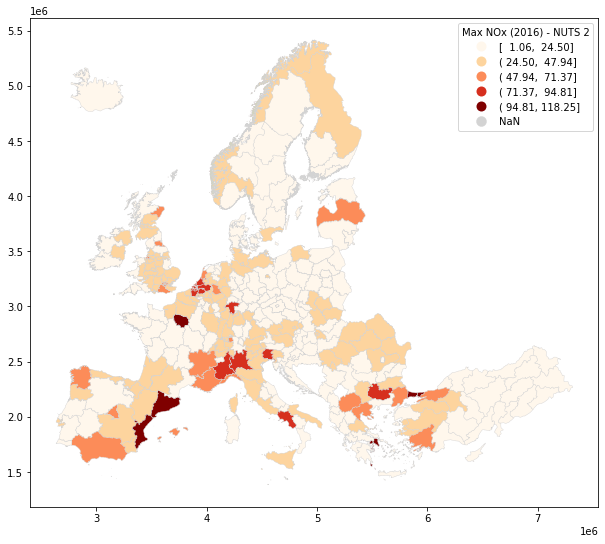

In [53]:
nox_nuts2_df.plot(column='nox_max', figsize=(12,9), scheme='equalinterval', cmap='OrRd', k=5,
    edgecolor="lightgrey", linewidth=0.4,
    legend=True, legend_kwds={'loc': 'upper right', 'title': 'Max NOx (2016) - NUTS 2'}, 
    missing_kwds = {'color': "lightgrey"})

- The distribution of NOx is very spatially heterogeneous (i.e., it varies a lot in each country).
- We can use `groupby` to find the top NUTS unit for each country in terms of maximum NOx:

In [54]:
nox_nuts2_df['nox_max_country_rank'] = nox_nuts2_df.groupby('CNTR_CODE')['nox_max'].rank(ascending=False)

In [55]:
# for each country, units are ranked internally
sel_df = nox_nuts2_df[['NUTS_ID','NUTS_NAME','nox_max','nox_max_country_rank']]
sel_df

,NUTS_ID,NUTS_NAME,nox_max,nox_max_country_rank
0,FRB0,Centre — Val de Loire,16.105000,21.0
1,CZ04,Severozápad,23.407000,2.0
2,CZ07,Střední Morava,17.278000,6.0
3,DK02,Sjælland,13.081000,4.0
4,ES12,Principado de Asturias,35.334999,8.0
...,...,...,...,...
320,TR52,"Konya, Karaman",13.056000,21.0
321,TR31,İzmir,40.974998,6.0
322,TR10,İstanbul,118.250999,1.0
323,TR32,"Aydın, Denizli, Muğla",60.021999,4.0


In [56]:
# select only top unit for each country (rank==1) and sort them by highest NOx max:
top_df = sel_df[sel_df['nox_max_country_rank']==1]
top_df.sort_values('nox_max', ascending=False)

,NUTS_ID,NUTS_NAME,nox_max,nox_max_country_rank
322,TR10,İstanbul,118.250999,1.0
14,ES51,Cataluña,108.094002,1.0
74,EL30,Aττική,106.764000,1.0
136,FR10,Ile-de-France,99.392998,1.0
42,BE21,Prov. Antwerpen,86.754997,1.0
177,ITC4,Lombardia,84.431000,1.0
43,BG42,Южен централен,83.987000,1.0
204,NL34,Zeeland,81.850998,1.0
85,DE71,Darmstadt,73.099998,1.0
234,UKI3,Inner London — West,60.915001,1.0


- In most European countries, the most polluted area in terms of NOx coincides with the most economically developed area. Can you spot exceptions?

End of notebook